Outlier dropped at index 3
Outlier dropped at index 5
Outlier dropped at index 6
Outlier dropped at index 8
Outlier dropped at index 12


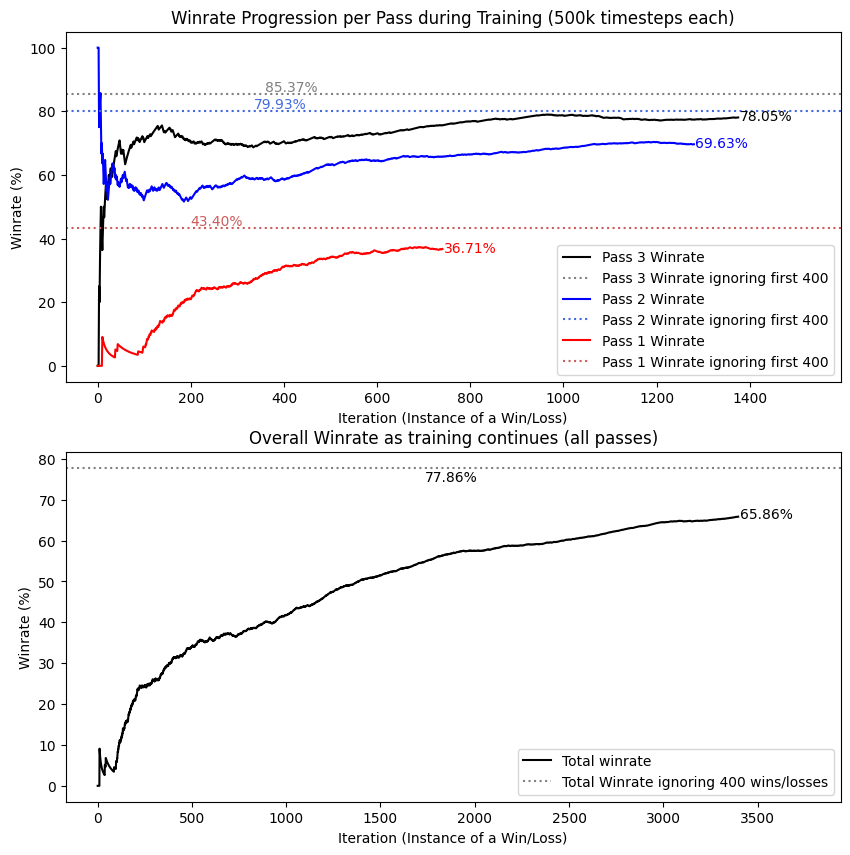

In [154]:
from typing import final
import pandas as pd                     # type: ignore
import matplotlib.pyplot as plt         # type: ignore
import matplotlib.gridspec as gridspec  # type: ignore

def convert_to_time(timesteps):
    tps = 80	        # estimated value for timesteps per second
    return round(timesteps / tps, 2)

def label_bars(ax, bars, color, append=""):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/100.0, yval, f'{yval:.2f}{append}', va='bottom', color=color)

# Read the file and extract the win/losses
def read_winloss_data(path):
    return pd.read_csv(path, header=None, names=['WinLoss', 'Pass'])

def calculate_iterative_winrate(winloss):
    iter_wins, iter_losses = {1: 0, 2: 0, 3: 0}, {1: 0, 2: 0, 3: 0}
    iter_wins_ignore, iter_losses_ignore = {1: 0, 2: 0, 3: 0}, {1: 0, 2: 0, 3: 0}
    iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore = {1: [], 2: [], 3: []}, {1: [], 2: [], 3: []}, [], []
    total_wins, total_losses, total_wins_ignore, total_losses_ignore = 0, 0, 0, 0

    for index, row in winloss.iterrows():
        pass_num = row['Pass']
        if row['WinLoss'] == 'win':
            iter_wins[pass_num] += 1
            if index >= IGNORE_PHASE + (iter_wins[pass_num - 1] if pass_num > 1 else 0) + (iter_losses[pass_num - 2] if pass_num > 2 else 0):
                iter_wins_ignore[pass_num] += 1
                total_wins_ignore += 1
            total_wins += 1
        elif row['WinLoss'] == 'loss':
            iter_losses[pass_num] += 1
            if index >= IGNORE_PHASE + (iter_wins[pass_num - 1] if pass_num > 1 else 0) + (iter_losses[pass_num - 1] if pass_num > 1 else 0) + (iter_wins[pass_num - 2] if pass_num > 2 else 0) + (iter_losses[pass_num - 2] if pass_num > 2 else 0):
                iter_losses_ignore[pass_num] += 1
                total_losses_ignore += 1
            total_losses += 1
        # Calculate winrate at this point and store it in the list
        if (iter_wins[pass_num] + iter_losses[pass_num]) > 0:
            iter_winlosses[pass_num].append(iter_wins[pass_num] / (iter_wins[pass_num] + iter_losses[pass_num]) * 100)
        if (iter_wins_ignore[pass_num] + iter_losses_ignore[pass_num]) > 0:
            iter_winlosses_ignore[pass_num].append(iter_wins_ignore[pass_num] / (iter_wins_ignore[pass_num] + iter_losses_ignore[pass_num]) * 100)
        if (total_wins + total_losses) > 0:
            total_winlosses.append(total_wins / (total_wins + total_losses) * 100)
        if (total_wins_ignore + total_losses_ignore) > 0:
            total_winlosses_ignore.append(total_wins_ignore / (total_wins_ignore + total_losses_ignore) * 100)
    return iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore

def plot_winrates(iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore):
    final_winrates = {k: (v[-1] if v else 0) for k, v in iter_winlosses.items()}
    final_ignore_winrates = {k: (v[-1] if v else 0) for k, v in iter_winlosses_ignore.items()}
    final_total_winrate = total_winlosses[-1] if total_winlosses else 0
    final_total_ignore_winrate = total_winlosses_ignore[-1] if total_winlosses_ignore else 0

    plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[1, 1])
    ax0, ax1 = plt.subplot(gs[0]), plt.subplot(gs[1])

    ax0.set_title('Winrate Progression per Pass during Training (500k timesteps each)')
    ax0.set_xlabel('Iteration (Instance of a Win/Loss)')
    ax0.set_ylabel('Winrate (%)')
    for pass_num in [3, 2, 1]:
        ax0.plot(iter_winlosses[pass_num], color=COLORS[f"p{pass_num}"], label=f'Pass {pass_num} Winrate')
        ax0.axhline(final_ignore_winrates[pass_num], color=COLORS[f"p{pass_num}_avg"], linestyle='dotted', label=f'Pass {pass_num} Winrate ignoring first {IGNORE_PHASE}')
        ax0.annotate(f'{final_winrates[pass_num]:.2f}%', xy=(len(iter_winlosses[pass_num])-1, final_winrates[pass_num]-1), xytext=(1, 0), textcoords='offset points', color=COLORS[f"p{pass_num}"])
        ax0.annotate(f'{final_ignore_winrates[pass_num]:.2f}%', xy=(len(iter_winlosses[pass_num])//4, final_ignore_winrates[pass_num]), xytext=(5, 2), textcoords='offset points', color=COLORS[f"p{pass_num}_avg"], fontsize=10)
    ax0.legend()

    ax1.set_title('Overall Winrate as training continues (all passes)')
    ax1.set_xlabel('Iteration (Instance of a Win/Loss)')
    ax1.set_ylabel('Winrate (%)')
    ax1.plot(total_winlosses, color='black', label='Total winrate')
    ax1.annotate(f'{final_total_winrate:.2f}%', xy=(len(total_winlosses)-1, final_total_winrate-0.5), xytext=(1, 0), textcoords='offset points', color='black', fontsize=10)
    ax1.axhline(y=final_total_ignore_winrate, color='gray', linestyle='dotted', label=f'Total Winrate ignoring {IGNORE_PHASE} wins/losses')
    ax1.annotate(f'{final_total_ignore_winrate:.2f}%', xy=(len(total_winlosses)//2, final_total_ignore_winrate), xytext=(5, -10), textcoords='offset points', color='black', fontsize=10)


    for ax in [ax0, ax1]:
        x_left, x_right = ax.get_xlim()
        padding = (x_right - x_left) * 0.1
        ax.set_xlim(x_left, x_right + padding)
        ax.legend()

    plt.show()

# Read the file and extract the levelbeat
def read_levelbeats_data(path):
    levelbeats = pd.read_csv(path, header=None, names=['completion_timesteps', 'training_timesteps', 'time_in_seconds'])

    # Remove outliers from levelbeat, although keep in mind they do represent massive amounts of exploration at the beginning of training
    dropped = 0
    indexes = [index for index, win_time in enumerate(levelbeats['completion_timesteps']) if win_time > 150000]
    for index in indexes:
        levelbeats = levelbeats.drop(index)
        print(f"Outlier dropped at index {index}")
        dropped += 1

    # Find the split in the .csv between Pass 1 and Pass 2
    with open(path, 'r') as file:
        lines = file.readlines()
    try:
        split_index1 = lines.index('\n') - dropped
        split_index2 = lines.index('\n', split_index1+1+dropped) - dropped -1
    except:
        split_index1 = len(levelbeats['completion_timesteps'])
        split_index2 = len(levelbeats['completion_timesteps'])

    # Split the data corresponding to Pass 1 and Pass 2, find averages & 5 fastests
    completion_t = {1: levelbeats['completion_timesteps'][:split_index1], 
                    2: levelbeats['completion_timesteps'][split_index1:split_index2], 
                    3: levelbeats['completion_timesteps'][split_index2:]}
    training_t = {1: levelbeats['training_timesteps'][:split_index1],
                  2: levelbeats['training_timesteps'][split_index1:split_index2],
                  3: levelbeats['training_timesteps'][split_index2:]}
    average_completion_t = {1: convert_to_time(completion_t[1][-CUTOFF:].mean()), 
                            2: convert_to_time(completion_t[2][-CUTOFF:].mean()), 
                            3: convert_to_time(completion_t[3][-CUTOFF:].mean())}
    fastest_completion_t = {1: levelbeats[:split_index1].nsmallest(5, 'completion_timesteps'),
                            2: levelbeats[split_index1:split_index2].nsmallest(5, 'completion_timesteps'),
                            3: levelbeats[split_index2:].nsmallest(5, 'completion_timesteps')}
    
    # def print_data():
    #     # Use to ensure split indexes are correct
    #     print("split_index1:", split_index1)
    #     print("split_index2:", split_index2)

    #     # Make sure dropping of indexes is correct
    #     # print(p1_training_t)
    #     # print(p2_training_t)
    #     # print(p3_training_t)

    #     # Print winrate info
    #     print(f'Pass 1 Winrates, len {len(p1_iter_winlosses)}: ...{p1_iter_winlosses[-5:]}')
    #     print(f'Pass 2 Winrates, len {len(p2_iter_winlosses)}: ...{p2_iter_winlosses[-5:]}')
    #     print(f'Pass 3 Winrates, len {len(p3_iter_winlosses)}: ...{p3_iter_winlosses[-5:]}')
    #     print(f'Overall Winrates, len {len(total_iter_winlosses)}')
    #     print(f"Pass 1 average completion time: {convert_to_time(p1_completion_t.mean())} seconds")
    #     print(f"Pass 2 average completion time: {convert_to_time(p2_completion_t.mean())} seconds")
    #     print(f"Pass 3 average completion time: {convert_to_time(p3_completion_t.mean())} seconds")
    #     print(f"Pass 1 average completion time for last {cutoff} wins: {average_pass1} seconds")
    #     print(f"Pass 2 average completion time for last {cutoff} wins: {average_pass2} seconds")
    #     print(f"Pass 3 average completion time for last {cutoff} wins: {average_pass3} seconds")
    # print_data()

    return completion_t, training_t, average_completion_t, fastest_completion_t


#Customization
COLORS = {
    "p1": "red", "p2": "blue", "p3": "black",
    "p1_avg": "indianred", "p2_avg": "royalblue", "p3_avg": "gray"
}
IGNORE_PHASE = 400      # Number of initial wins/losses to ignore for winrate calculation
CUTOFF = 100            # Number of last wins to consider for average completion time
LEVELBEATS_PATH = './logs/levelbeats copy 4.csv'
WINLOSS_PATH = './logs/winloss copy 2.csv'

def main():
    winloss = read_winloss_data(WINLOSS_PATH)
    levelbeats = read_levelbeats_data(LEVELBEATS_PATH)
    iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore = calculate_iterative_winrate(winloss)
    plot_winrates(iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore)

if __name__ == "__main__":
    main()

Outlier dropped at index 3
Outlier dropped at index 5
Outlier dropped at index 6
Outlier dropped at index 8
Outlier dropped at index 12


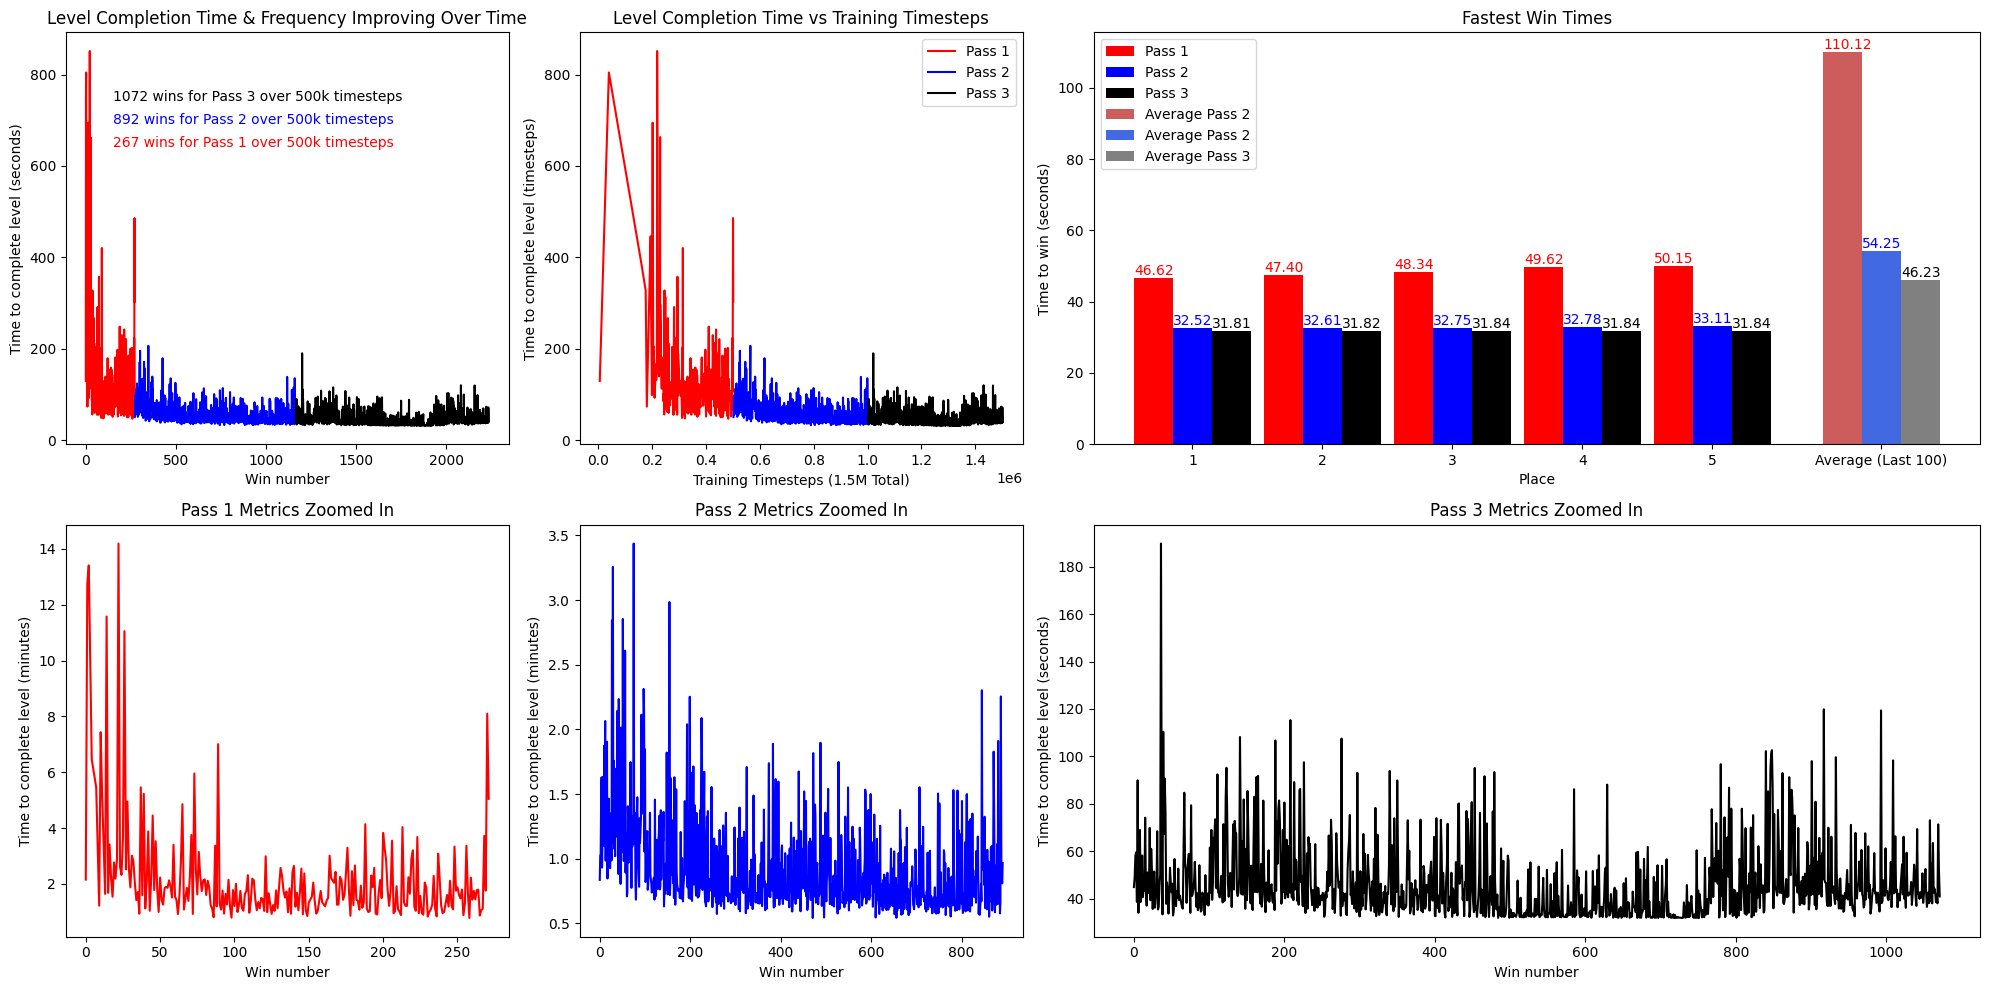

In [155]:
from cProfile import label


def plot_levelbeats(completion_t, training_t, average_completion_t, fastest_completion_t):
    # Graph setup
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 2], height_ratios=[1, 1])
    ax0, ax1, ax2, ax3, ax4, ax5 = plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2]), plt.subplot(gs[3]), plt.subplot(gs[4]), plt.subplot(gs[5])

    for i in [1, 2, 3]:
        # Graph level completion time and frequency improving over time
        ax0.plot(convert_to_time(completion_t[i]), color=COLORS[f"p{i}"], label=f'Pass {i}')
        ax0.text(150, 600 + 50 * i, f'{len(completion_t[i])} wins for Pass {i} over 500k timesteps', color=COLORS[f"p{i}"], verticalalignment='center', horizontalalignment='left')
         # Graph level completion time vs training timesteps
        ax1.plot(training_t[i] + 500000 * (i - 1), convert_to_time(completion_t[i]), color=COLORS[f"p{i}"], label=f'Pass {i}')
    ax0.set_title('Level Completion Time & Frequency Improving Over Time')
    ax0.set_ylabel('Time to complete level (seconds)')
    ax0.set_xlabel('Win number')
    ax1.set_title('Level Completion Time vs Training Timesteps')
    ax1.set_xlabel('Training Timesteps (1.5M Total)')
    ax1.set_ylabel('Time to complete level (timesteps)')
    ax1.legend(loc='upper right')

    # Graph the bar chart, showing fastest speeds and average of the last 100 wins for each pass
    width = 0.3
    
    indices = {}
    indices.update({1: range(len(fastest_completion_t[1]))})
    indices.update({2: [index + width for index in indices[1]]})
    indices.update({3: [index + width for index in indices[2]]})

    for i in [1, 2, 3]:
        bars = ax2.bar(indices[i], convert_to_time(fastest_completion_t[i]['completion_timesteps']), width=width, label=f'Pass {i}', color=COLORS[f"p{i}"])
        label_bars(ax2, bars, COLORS[f"p{i}"])
    bars1_avg = ax2.bar([max(indices[2]) + 1],           [average_completion_t[1]],                                        width=width, label='Average Pass 2', color=COLORS[f"p{1}_avg"])
    bars2_avg = ax2.bar([max(indices[2]) + 1 + width],   [average_completion_t[2]],                                        width=width, label='Average Pass 2', color=COLORS[f"p{2}_avg"])
    bars3_avg = ax2.bar([max(indices[3]) + 1 + width],   [average_completion_t[3]],                                        width=width, label='Average Pass 3', color=COLORS[f"p{3}_avg"])
    label_bars(ax2, bars1_avg, COLORS[f"p1"])
    label_bars(ax2, bars2_avg, COLORS[f"p2"])
    label_bars(ax2, bars3_avg, COLORS[f"p3"])

    ax2.set_xticks(list(indices[2]) + [max(indices[3]) + 1])                          # Set x-ticks to indices and "Average" position
    ax2.set_xticklabels(list(range(1, len(fastest_completion_t[1]) + 1)) + [f'Average (Last {CUTOFF})'])    # Set x-tick labels to index numbers and "Average"
    ax2.set_title('Fastest Win Times')
    ax2.set_ylabel('Time to win (seconds)')
    ax2.set_xlabel('Place')
    ax2.legend()

    # Graph the zoomed in metrics for each pass
    ax3.plot(convert_to_time(completion_t[1]) / 60, color=COLORS["p1"])
    ax3.set_title('Pass 1 Metrics Zoomed In')
    ax3.set_ylabel('Time to complete level (minutes)')
    ax3.set_xlabel('Win number')
    x_values = range(len(convert_to_time(completion_t[2])))
    ax4.plot([x for x in x_values], convert_to_time(completion_t[2]) / 60, color=COLORS["p2"])
    ax4.set_title('Pass 2 Metrics Zoomed In')
    ax4.set_ylabel('Time to complete level (minutes)')
    ax4.set_xlabel('Win number')
    x_values = range(len(convert_to_time(completion_t[3])))
    ax5.plot([x for x in x_values], convert_to_time(completion_t[3]), color=COLORS["p3"])
    ax5.set_title('Pass 3 Metrics Zoomed In')
    ax5.set_ylabel('Time to complete level (seconds)')
    ax5.set_xlabel('Win number')

    # Show the graph
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

def main():
    completion_t, training_t, average_completion_t, fastest_completion_t = read_levelbeats_data(LEVELBEATS_PATH)
    plot_levelbeats(completion_t, training_t, average_completion_t, fastest_completion_t)

if __name__ == "__main__":
    main()